In [ ]:
import pandas as pd
import numpy as np
import os
import json
import spacy

In [ ]:
def read_json_file(path):
    f = open(path)
    json_content = json.load(f)
    f.close()
    return json_content


training_data_directory = 'data/rumoureval-2019-training-data/twitter-english'
test_data_directory = 'data/rumoureval-2019-test-data/twitter-en-test-data'
eval_data_directory = 'data/rumoureval-2019-test-data/twitter-eval-data'

training_data_reddit_directory_dev = 'data/rumoureval-2019-training-data/reddit-dev-data'
training_data_reddit_directory = 'data/rumoureval-2019-training-data/reddit-training-data'
test_data_reddit_directory = 'data/rumoureval-2019-test-data/reddit-test-data'

training_labels_json = 'data/rumoureval-2019-training-data/train-key.json'
training_labels_json_2 = 'data/rumoureval-2019-training-data/dev-key.json'
test_labels_json = 'data/final-eval-key.json'

training_labels_dict = read_json_file(training_labels_json)['subtaskaenglish']
training_labels_dict.update(read_json_file(training_labels_json_2)['subtaskaenglish'])
test_labels_dict = read_json_file(test_labels_json)['subtaskaenglish']

In [ ]:
class Tweet:
    def __init__(self, text,favorite_count, id, hastags,
                 retweet_count, verified,  parent_id=None):
        self.label = None
        self.id = id
        self.favorite_count = favorite_count
        self.text= text
        self.parent_id = parent_id
        self.user_metadata = None
        self.hastags=hastags
        self.retweet_count=retweet_count
        self.verified = verified,
        self.direct_replies = []



In [ ]:
def read_tweets_dataset(dataset_dir_path):
    topic_directories = [f.path for f in os.scandir(dataset_dir_path) if f.is_dir()]

    tweets = []
    for topic_dir in topic_directories:



        tweets_paths = [f.path for f in os.scandir(topic_dir) if f.is_dir()]
        for tweet_dir in tweets_paths:
            source_tweet_path = [f.path for f in os.scandir(tweet_dir + '/source-tweet')][0]
            source_tweet_json = read_json_file(source_tweet_path)
            source_tweet_hastags = source_tweet_json['entities']['hashtags']
            hashtags_text_array = [h['text'] for h in source_tweet_hastags]
            tweet = Tweet(source_tweet_json['text'],id= source_tweet_json['id'],
                          hastags=hashtags_text_array,
                          verified=source_tweet_json['user']['verified'],
                          retweet_count=source_tweet_json['retweet_count'],
                          favorite_count=source_tweet_json['favorite_count'],
                          )




            reply_tweets = []
            reply_tweets_paths = [f.path for f in os.scandir(tweet_dir + '/replies')]
            for reply_tweet_path in reply_tweets_paths:
                reply_tweet_json = read_json_file(reply_tweet_path)
                reply_tweet_hastags = reply_tweet_json['entities']['hashtags']
                hashtags_text_array = [h['text'] for h in reply_tweet_hastags]
                reply_tweet = Tweet(reply_tweet_json['text'],
                                    id=reply_tweet_json['id'],
                                  hastags=hashtags_text_array,
                                    parent_id=reply_tweet_json['in_reply_to_status_id'],
                                  verified=reply_tweet_json['user']['verified'],
                                  retweet_count=reply_tweet_json['retweet_count'],
                                  favorite_count=reply_tweet_json['favorite_count'],
                                    )
                reply_tweets.append(reply_tweet)
            tweets.append({'source':tweet, 'replies':reply_tweets})


    return tweets

In [ ]:
def tree(tweets):
    for tweet in tweets:
        source_id = tweet['source'].id
        for dabila in tweet['replies']:
            if dabila.parent_id == source_id:
                tweet['source'].direct_replies.append(dabila)
            for abudzaba in tweet['replies']:
                if abudzaba.id == dabila.parent_id:
                    abudzaba.direct_replies.append(dabila)
    return tweets

tweets = read_tweets_dataset(training_data_directory)
tweets_test = read_tweets_dataset(test_data_directory)
tweets_eval = read_tweets_dataset(eval_data_directory)
tweets = tree(tweets)
tweets_test = tree(tweets_test)
tweets_eval = tree(tweets_eval)
print(tweets[0]['source'].direct_replies)

print(len(tweets[0]['replies']))

[<__main__.Tweet object at 0x0000027119F3B700>, <__main__.Tweet object at 0x0000027119F398A0>, <__main__.Tweet object at 0x0000027119F3AF80>]
5


In [ ]:
print(tweets[1]['source'].id)
print(tweets[1]['source'].direct_replies[0].id)
print(tweets_test[1]['source'].id)

552785375161499649
552785851655393281
443938194715713536


In [ ]:
labels = read_json_file(training_labels_json)
labels2 = read_json_file(training_labels_json_2)
test_labels = read_json_file(test_labels_json)

subA = labels['subtaskaenglish']
subAdev = labels2['subtaskaenglish']
subTest =  test_labels['subtaskaenglish']
new = subA | subAdev

In [301]:

for tweet in tweets:
    for rep in tweet['replies']:
        rep.label = new[str(rep.id)]

for tweet in tweets_test:
    for rep in tweet['replies']:
        rep.label = subTest[str(rep.id)]
for tweet in tweets_eval:
    for rep in tweet['replies']:
        rep.label = subTest[str(rep.id)]

In [302]:
print(tweets[0]['replies'][0].id)
print(tweets[0]['replies'][0].label)

552785374507175936
comment


In [303]:
import string
import re
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")


You should consider upgrading via the 'C:\Users\filip\coding\apt_projekt\venv\Scripts\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [304]:
punctuation = string.punctuation.replace("!", "")
punctuation = punctuation.replace("?", "")

In [305]:

def preprocessing(sentence):
    lemmatizer = nlp.get_pipe("lemmatizer")
    doc = nlp(sentence)
    lemmas = []
    for token in doc:

        if token.is_stop or token.like_url:
            continue

        elif re.search(r"@\w+", token.text):
            continue
        elif token.pos_ == "NUM":
            lemmas.append('#')
        elif token.pos_ == "SYM":

            continue
        elif token.text in punctuation:
            continue

        else:
            lemmas.append(token.lemma_.lower())
    return lemmas

In [306]:
def create_df(tweet_list):
    rows = []
    for tweet in  tweet_list:
        source_tweet_token = preprocessing(tweet['source'].text)
        for reply in tweet['replies']:
                dir_labels = []
                reply_token = preprocessing(reply.text)
                for rep_dir in reply.direct_replies:
                    dir_labels.append(rep_dir.label)
                if str(reply.parent_id) in new:
                    parent_label = new[str(reply.parent_id)]
                elif str(reply.parent_id) in subTest:
                    parent_label = subTest[str(reply.parent_id)]
                else:
                    parent_label = "None"
                rows.append((tweet['source'].text, reply.text,source_tweet_token, reply_token,  reply.label,parent_label, reply.id,
                             reply.hastags, reply.favorite_count,
                             reply.retweet_count, tweet['source'].favorite_count,tweet['source'].hastags,tweet['source'].retweet_count,dir_labels))

    return pd.DataFrame(rows, columns=[ 'original_source_tweet', 'original_reply', 'source_tweet_token', 'reply_token','reply_label','parent_label','reply_id','reply_hashtags','reply_fav_count','reply_ret_count','source_fav_count','source_hashtags','source_ret_count','rep_labels'])

In [307]:
df = create_df(tweets)
df_test = create_df(tweets_test)
df_eval = create_df(tweets_eval)
df_test.head(50)

,original_source_tweet,original_reply,source_tweet_token,reply_token,reply_label,parent_label,reply_id,reply_hashtags,reply_fav_count,reply_ret_count,source_fav_count,source_hashtags,source_ret_count,rep_labels
0,#Breaking: Pentagon releases video of the “mot...,@TODAYshow \n\nBig expensive payload to kill 3...,"[break, pentagon, release, video, "", mother, b...","[\n\n, big, expensive, payload, kill, #, people]",comment,support,852844865864044544,[],1,1,154,[Breaking],124,[]
1,#Breaking: Pentagon releases video of the “mot...,@TODAYshow How many ISIS did it kill?,"[break, pentagon, release, video, "", mother, b...","[isis, kill, ?]",query,support,852845372338786305,[],0,0,154,[Breaking],124,[]
2,#Breaking: Pentagon releases video of the “mot...,@TODAYshow @HallieJackson The mother... give m...,"[break, pentagon, release, video, "", mother, b...","[mother, ..., beak, man, thing, childish]",comment,support,852845811687981056,[],1,0,154,[Breaking],124,[]
3,#Breaking: Pentagon releases video of the “mot...,"@TODAYshow \nBefore and after, looks like ther...","[break, pentagon, release, video, "", mother, b...","[\n, look, like, wipe, landscape]",comment,support,852846445497593856,[],0,0,154,[Breaking],124,[]
4,#Breaking: Pentagon releases video of the “mot...,@TODAYshow The next one could be the Daddy of ...,"[break, pentagon, release, video, "", mother, b...","[daddy, bomb, destruction, mankind, !, stop, m...",comment,support,852847738224037888,[],7,2,154,[Breaking],124,[]
5,#Breaking: Pentagon releases video of the “mot...,"@TODAYshow @HallieJackson Hallie, take another...","[break, pentagon, release, video, "", mother, b...","[hallie, listen, segment, morning, spot, hear,...",comment,support,852849295363637248,[],0,0,154,[Breaking],124,[]
6,#Breaking: Pentagon releases video of the “mot...,@TODAYshow @HallieJackson I wish media would r...,"[break, pentagon, release, video, "", mother, b...","[wish, medium, refuse, distribute, bomb, porn,...",comment,support,852849301415972864,[],4,1,154,[Breaking],124,[]
7,#Breaking: Pentagon releases video of the “mot...,"@TODAYshow Trumps ""very proud"" of his recent b...","[break, pentagon, release, video, "", mother, b...","[trumps, proud, recent, bomb, attack, guess, p...",comment,support,852851039145529345,[],1,0,154,[Breaking],124,[]
8,#Breaking: Pentagon releases video of the “mot...,@TODAYshow I hope that dirt patch finally lear...,"[break, pentagon, release, video, "", mother, b...","[hope, dirt, patch, finally, learn, lesson, !,...",comment,support,852855015853236224,[],5,0,154,[Breaking],124,[]
9,#Breaking: Pentagon releases video of the “mot...,@TODAYshow What a beautiful sight!,"[break, pentagon, release, video, "", mother, b...","[beautiful, sight, !]",comment,support,852855258824941569,[],4,0,154,[Breaking],124,[]


In [308]:
def has_hashtags(hashtags_list):
    if len(hashtags_list) > 0:
        return 1
    else:
        return 0

df['has_reply_hashtags'] = df['reply_hashtags'].apply(has_hashtags)
df_test['has_reply_hashtags'] = df_test['reply_hashtags'].apply(has_hashtags)
df_eval['has_reply_hashtags'] = df_eval['reply_hashtags'].apply(has_hashtags)

# print the u
df.head(20)

,original_source_tweet,original_reply,source_tweet_token,reply_token,reply_label,parent_label,reply_id,reply_hashtags,reply_fav_count,reply_ret_count,source_fav_count,source_hashtags,source_ret_count,rep_labels,has_reply_hashtags
0,France: 10 people dead after shooting at HQ of...,MT @euronews France: 10 dead after shooting at...,"[france, #, people, dead, shoot, hq, satirical...","[mt, france, #, dead, shoot, hq, satirical, we...",comment,support,552785374507175936,[CharlieHebdo],2,1,38,[CharlieHebdo],486,[deny],1
1,France: 10 people dead after shooting at HQ of...,@j0nathandavis They who? Stupid and partial op...,"[france, #, people, dead, shoot, hq, satirical...","[?, stupid, partial, opinion, like, add, noise...",deny,comment,552786226546495488,[],0,0,38,[CharlieHebdo],486,[comment],0
2,France: 10 people dead after shooting at HQ of...,"@nanoSpawn Socialists, Antisemites, anti zioni...","[france, #, people, dead, shoot, hq, satirical...","[socialists, antisemites, anti, zionist, usual...",comment,deny,552789345628069888,[],0,0,38,[CharlieHebdo],486,[],0
3,France: 10 people dead after shooting at HQ of...,@euronews @TradeDesk_Steve A French crime of p...,"[france, #, people, dead, shoot, hq, satirical...","[french, crime, passion, heathen, moslem, atro...",query,support,552792862610694144,[],0,0,38,[CharlieHebdo],486,[],0
4,France: 10 people dead after shooting at HQ of...,"@euronews LOL. 5 million Muslims in France, wh...","[france, #, people, dead, shoot, hq, satirical...","[lol, #, #, muslims, france, disgrace, french,...",comment,support,552943855021330432,[],0,0,38,[CharlieHebdo],486,[],0
5,BREAKING: 10 reportedly shot dead at Paris HQ ...,@Independent How dreadful.,"[breaking, #, reportedly, shoot, dead, paris, ...",[dreadful],support,support,552785851655393281,[],0,0,5,[],128,[],0
6,BREAKING: 10 reportedly shot dead at Paris HQ ...,"Nowhere is safe anymore? ""@independent","[breaking, #, reportedly, shoot, dead, paris, ...","[safe, anymore, ?]",support,support,552785877748158464,[],0,0,5,[],128,[],0
7,BREAKING: 10 reportedly shot dead at Paris HQ ...,@Independent why does one feel that this may h...,"[breaking, #, reportedly, shoot, dead, paris, ...","[feel, freedom, speech]",comment,support,552788073340489728,[],0,0,5,[],128,[],0
8,Appalled by the attack on Charlie Hebdo in Par...,@tnewtondunn You guys should put one of their ...,"[appal, attack, charlie, hebdo, paris, #, prob...","[guy, cartoon, maybe, tweet, page, tomorrow]",comment,support,552789083211460608,[],6,12,64,[],166,"[comment, comment]",0
9,Appalled by the attack on Charlie Hebdo in Par...,@tnewtondunn Important moment. Other papers co...,"[appal, attack, charlie, hebdo, paris, #, prob...","[important, moment, paper, provide, safety, nu...",comment,support,552789147606581248,[],1,0,64,[],166,[],0


Some useful features for the future

In [309]:
def has_link(tweet):
    pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return bool(re.search(pattern, tweet))


df['has_link'] = df['original_reply'].apply(has_link)
df_test['has_link'] = df_test['original_reply'].apply(has_link)
df_eval['has_link'] = df_eval['original_reply'].apply(has_link)

news_agencies = ['@cnn', '@bbc', '@reuters', '@nytimes', '@foxnews', '@abc', '@cbsnews', '@ap']


def mentions_news_agency(tweet):
    for agency in news_agencies:
        if agency in tweet.lower():
            return True
    return False


df['mentions_news_agency'] = df['original_reply'].apply(mentions_news_agency)
df_test['mentions_news_agency'] = df_test['original_reply'].apply(mentions_news_agency)
df_eval['mentions_news_agency'] = df_eval['original_reply'].apply(mentions_news_agency)

one_hot_encoded_parent = pd.get_dummies(df['parent_label'])
one_hot_encoded_parent_test = pd.get_dummies(df_test['parent_label'])
one_hot_encoded_parent_eval = pd.get_dummies(df_eval['parent_label'])

df = pd.concat([df, one_hot_encoded_parent], axis=1)
df_test = pd.concat([df_test, one_hot_encoded_parent_test], axis=1)
df_eval = pd.concat([df_eval, one_hot_encoded_parent_eval], axis=1)
def calculate_value(stance_list):
    value = 0
    for stance in stance_list:
        if stance == 'deny':
            value -= 1
        elif stance == 'support':
            value += 1
    return value


df['value'] = df['rep_labels'].apply(calculate_value)
df_test['value'] = df_test['rep_labels'].apply(calculate_value)
df_eval['value'] = df_eval['rep_labels'].apply(calculate_value)


df['reply_count'] = df['rep_labels'].apply(len)
df_test['reply_count'] = df_test['rep_labels'].apply(len)
df_eval['reply_count'] = df_eval['rep_labels'].apply(len)




In [310]:
df_test.head(100)

,original_source_tweet,original_reply,source_tweet_token,reply_token,reply_label,parent_label,reply_id,reply_hashtags,reply_fav_count,reply_ret_count,...,rep_labels,has_reply_hashtags,has_link,mentions_news_agency,None,comment,query,support,value,reply_count
0,#Breaking: Pentagon releases video of the “mot...,@TODAYshow \n\nBig expensive payload to kill 3...,"[break, pentagon, release, video, "", mother, b...","[\n\n, big, expensive, payload, kill, #, people]",comment,support,852844865864044544,[],1,1,...,[],0,False,False,False,False,False,True,0,0
1,#Breaking: Pentagon releases video of the “mot...,@TODAYshow How many ISIS did it kill?,"[break, pentagon, release, video, "", mother, b...","[isis, kill, ?]",query,support,852845372338786305,[],0,0,...,[],0,False,False,False,False,False,True,0,0
2,#Breaking: Pentagon releases video of the “mot...,@TODAYshow @HallieJackson The mother... give m...,"[break, pentagon, release, video, "", mother, b...","[mother, ..., beak, man, thing, childish]",comment,support,852845811687981056,[],1,0,...,[],0,False,False,False,False,False,True,0,0
3,#Breaking: Pentagon releases video of the “mot...,"@TODAYshow \nBefore and after, looks like ther...","[break, pentagon, release, video, "", mother, b...","[\n, look, like, wipe, landscape]",comment,support,852846445497593856,[],0,0,...,[],0,False,False,False,False,False,True,0,0
4,#Breaking: Pentagon releases video of the “mot...,@TODAYshow The next one could be the Daddy of ...,"[break, pentagon, release, video, "", mother, b...","[daddy, bomb, destruction, mankind, !, stop, m...",comment,support,852847738224037888,[],7,2,...,[],0,False,False,False,False,False,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"A remembrance.\n\n""What I'm hearing, which is ...",@wcruz73 @courtofsatyrs At least she made sure...,"[remembrance, \n\n, hear, sort, scary, want, s...","[sure, kid, able, read, shitty, family]",comment,support,987956393385672704,[],0,0,...,[comment],0,False,False,False,False,False,True,0,1
96,"A remembrance.\n\n""What I'm hearing, which is ...",@Rabid_Ra33it @wcruz73 @courtofsatyrs They are...,"[remembrance, \n\n, hear, sort, scary, want, s...","[fine, family, maybe, mistake, honorable, amer...",comment,comment,988015563933962240,[],0,0,...,[comment],0,False,False,False,True,False,False,0,1
97,"A remembrance.\n\n""What I'm hearing, which is ...",@wcruz73 I remember that vividly. She said som...,"[remembrance, \n\n, hear, sort, scary, want, s...","[remember, vividly, say, good, thing, drop, ja...",comment,support,988030220753088512,[],0,0,...,[],0,False,False,False,False,False,True,0,0
98,"A remembrance.\n\n""What I'm hearing, which is ...",@bennie4561 @wcruz73 @courtofsatyrs The harm t...,"[remembrance, \n\n, hear, sort, scary, want, s...","[harm, family, far, outweigh, good]",comment,comment,988139971566489600,[],1,0,...,[],0,False,False,False,True,False,False,0,0


In [311]:
booldean_columns = ['has_link', 'mentions_news_agency', 'comment', 'query', 'support', 'deny']

df_test['deny'] = False
df_eval['deny'] = False
df_eval['comment'] = False
df[booldean_columns] = df[booldean_columns].astype(int)
df_test[booldean_columns] = df_test[booldean_columns].astype(int)
df_eval[booldean_columns] = df_eval[booldean_columns].astype(int)
df_eval.head()

,original_source_tweet,original_reply,source_tweet_token,reply_token,reply_label,parent_label,reply_id,reply_hashtags,reply_fav_count,reply_ret_count,...,rep_labels,has_reply_hashtags,has_link,mentions_news_agency,query,support,value,reply_count,deny,comment
0,Noah’s Ark Theme Park Destroyed in a Flood? ht...,@snopes It really was too good to be true.,"[noah, ark, theme, park, destroyed, flood, ?]","[good, true]",comment,query,897503095403421696,[],1,0,...,[],0,0,0,1,0,0,0,0,0
1,Noah’s Ark Theme Park Destroyed in a Flood? ht...,@snopes I so want someone to buy it and turn i...,"[noah, ark, theme, park, destroyed, flood, ?]","[want, buy, turn, pastafarian, pirate, ship, \n]",comment,query,897503340958957569,[],0,0,...,[],0,1,0,1,0,0,0,0,0
2,Noah’s Ark Theme Park Destroyed in a Flood? ht...,@snopes No way. That boat's far too *fabulous*...,"[noah, ark, theme, park, destroyed, flood, ?]","[way, boat, far, fabulous, like, ;)]",deny,query,897504112001994754,[],0,0,...,[],0,1,0,1,0,0,0,0,0
3,Noah’s Ark Theme Park Destroyed in a Flood? ht...,@snopes This could have made my day,"[noah, ark, theme, park, destroyed, flood, ?]",[day],comment,query,897504885591089153,[],0,0,...,[],0,0,0,1,0,0,0,0,0
4,Noah’s Ark Theme Park Destroyed in a Flood? ht...,@snopes https://t.co/DJqcRHaIvw,"[noah, ark, theme, park, destroyed, flood, ?]",[ ],comment,query,897524701446246400,[],0,0,...,[],0,1,0,1,0,0,0,0,0


<Axes: >

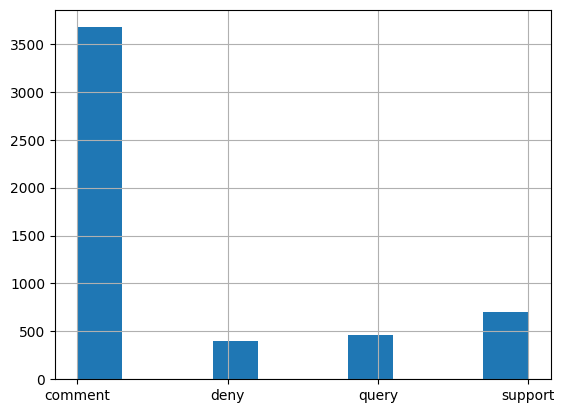

In [312]:
import matplotlib
df['reply_label'].hist()

<Axes: >

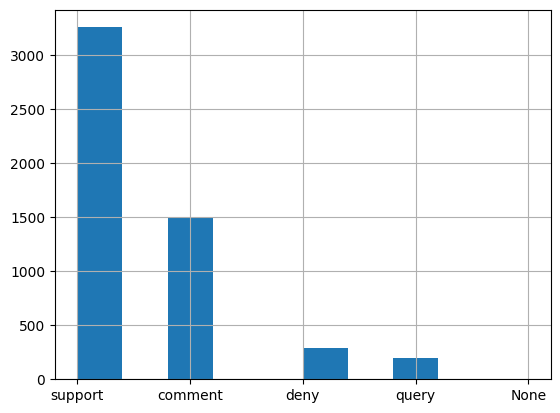

In [313]:
df['parent_label'].hist()

<Axes: >

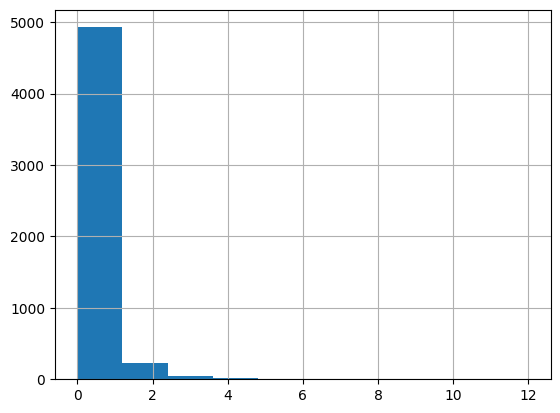

In [314]:
df['reply_count'].hist()

In [315]:

training_data = df[['reply_token', 'reply_label', 'has_reply_hashtags','reply_ret_count']].values
testing_data = df_test[['reply_token', 'reply_label', 'has_reply_hashtags','reply_ret_count']].values



In [316]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
label_map = {'comment':0, 'support':1, 'deny':2, 'query':3}

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
#print(training_data[:,2:])
def tfidf_vectorize(data, ngram, count_vect=None):


    text_data = []
    labels = []
    for i in data:
        text_data.append(' '.join(i[0]))
        labels.append(label_map[i[1]])

    if count_vect is None:
        count_vect = TfidfVectorizer(ngram_range=(ngram, ngram), token_pattern = '[a-zA-Z0-9#?!]+')

        count_vect.fit(text_data)
        # print(count_vect.get_feature_names_out())

    vectorized_data = count_vect.transform(text_data)

    return vectorized_data, np.array(labels), count_vect

# print(training_data[:5])
X_train, y_train, count_vect = tfidf_vectorize(training_data, 2)
new_feature = df['reply_ret_count'].values.reshape(-1, 1)
new_feature_test = df_test['reply_ret_count'].values.reshape(-1, 1)
combined_data = np.hstack((X_train.toarray(), df['has_reply_hashtags'].values.reshape(-1, 1), new_feature))

X_test,y_test, count_vect_test = tfidf_vectorize(testing_data, 2, count_vect)
combined_data_test = np.hstack((X_test.toarray(), df_test['has_reply_hashtags'].values.reshape(-1, 1),new_feature_test))

#print(X_train)


In [317]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.linear_model import SGDClassifier
MNB = MultinomialNB()
MNB.fit(combined_data, y_train)
y_pred = MNB.predict(combined_data_test)

print(" Classification accuracy: ", accuracy_score(y_test, y_pred))
print(" Micro F1 score: ", f1_score(y_test, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(y_test, y_pred, average='macro'))

 Classification accuracy:  0.7633663366336634
 Micro F1 score:  0.7633663366336635
 Macro F1 score:  0.21645143177989892


In [318]:

LR = LogisticRegression(max_iter = 1000)
LR.fit(combined_data, y_train)
y_pred = LR.predict(combined_data_test)
print(" Classification accuracy: ", accuracy_score(y_test, y_pred))
print(" Micro F1 score: ", f1_score(y_test, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(y_test, y_pred, average='macro'))

 Classification accuracy:  0.7663366336633664
 Micro F1 score:  0.7663366336633662
 Macro F1 score:  0.2689054726368159


In [319]:


SGD = SGDClassifier(max_iter=1000, random_state=0)
SGD.fit(combined_data, y_train)
y_pred = SGD.predict(combined_data_test)
print(" Classification accuracy: ", accuracy_score(y_test, y_pred))
print(" Micro F1 score: ", f1_score(y_test, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(y_test, y_pred, average='macro'))
classification_report(y_test, y_pred)

 Classification accuracy:  0.7613861386138614
 Micro F1 score:  0.7613861386138614
 Macro F1 score:  0.2925401947090974


'              precision    recall  f1-score   support\n\n           0       0.77      0.98      0.86       771\n           1       0.00      0.00      0.00        91\n           2       0.50      0.01      0.02        92\n           3       0.52      0.20      0.29        56\n\n    accuracy                           0.76      1010\n   macro avg       0.45      0.30      0.29      1010\nweighted avg       0.66      0.76      0.68      1010\n'

In [320]:
from textblob import TextBlob
import gensim.downloader as api
model = api.load("glove-twitter-25")

embedding_length = 25

#functions for features
def embedings(sentence, features):
    doc = nlp(sentence)

    word_embeddings = []

    number = 0
    for token in doc:
        if token.is_stop:
            continue
        if token.pos_ == "NUM":
            number = 1
        # 25 features
        elif token.text in model:
            word_embeddings.append(model[token.text])

    if len(word_embeddings) == 0:
        word_embeddings.append([0]*embedding_length)

    word_embeddings = np.array(word_embeddings)

    # mean word embedding
    features.extend(list(np.mean(word_embeddings, axis = 0)))

    # contains number
    features.append(number)
    return features


def exclamation(sentence, features):
    if sentence.find('?'):
        features.append(1)
    else:
        features.append(0)

    # contains !
    if sentence.find('!'):
        features.append(1)
    else:
        features.append(0)
    return features


def capital_retio(sentence, features):
    uppers = [i for i in sentence if i.isupper()]
    capitalratio = len(uppers)/len(sentence)
    features.append(capitalratio)
    return features

def lenght(sentence, features):
    features.append(len(sentence))
    return  features

def polar(sentence, features):
    pol = TextBlob(sentence).sentiment.polarity
    features.append(pol)
    return features




In [347]:
training_data = df[['original_reply','has_link', 'mentions_news_agency' ,'reply_label']].values
testing_data = df_test[['original_reply','has_link', 'mentions_news_agency', 'reply_label',]].values
eval_data = df_eval[['original_reply','has_link', 'mentions_news_agency', 'reply_label',]].values

In [322]:
def fetureazer_no_context(data):

    labels = []
    features = []
    for i in data[:,0]:
        fet = []
        fet = embedings(i, fet)
        fet = exclamation(i, fet)
        fet = capital_retio(i, fet)
        fet = lenght(i, fet)
        fet = polar(i, fet)
        features.append(fet)
    for i in data[:,-1]:
        labels.append(label_map[i])

    features_array = np.array(features)
    labels_array = np.array(labels)
    for i in range(1, 3):
        new_column_array = data[:, i].reshape(-1, 1)
        features_array = np.hstack((features_array, new_column_array))

    return features_array, labels_array

In [348]:
training_features, training_labels = fetureazer_no_context(training_data)
testing_features, testing_labels = fetureazer_no_context(testing_data)
eval_features, eval_labels = fetureazer_no_context(eval_data)

In [323]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(training_features, training_labels)
y_pred = RF.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

 Classification accuracy:  0.7623762376237624
 Micro F1 score:  0.7623762376237624
 Macro F1 score:  0.2624618869239481
              precision    recall  f1-score   support

           0       0.77      0.99      0.87       771
           1       0.00      0.00      0.00        91
           2       0.00      0.00      0.00        92
           3       0.67      0.11      0.18        56

    accuracy                           0.76      1010
   macro avg       0.36      0.27      0.26      1010
weighted avg       0.62      0.76      0.67      1010



c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [324]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(n_estimators=300, learning_rate=1, max_depth=10)
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

 Classification accuracy:  0.7217821782178218
 Micro F1 score:  0.7217821782178218
 Macro F1 score:  0.32120457449470047
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       771
           1       0.19      0.15      0.17        91
           2       0.10      0.01      0.02        92
           3       0.34      0.20      0.25        56

    accuracy                           0.72      1010
   macro avg       0.36      0.32      0.32      1010
weighted avg       0.64      0.72      0.67      1010



In [325]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [5, 10, 15]
}

GBC = GradientBoostingClassifier()
final_params = [100, 0.1, 5]
f1_best = 0
for i in param_grid['n_estimators']:
    for j in param_grid['learning_rate']:
        for z in param_grid['max_depth']:

            GBC = GradientBoostingClassifier(n_estimators=i, learning_rate=j, max_depth=z)
            GBC.fit(training_features, training_labels)
            y_pred = GBC.predict(eval_features)
            f1 = f1_score(eval_labels, y_pred, average='macro')
            if f1 > f1_best:
                final_params = [i, j, z]
                f1_best = f1

print(final_params)

GBC = GradientBoostingClassifier(n_estimators=final_params[0], learning_rate=final_params[1], max_depth=final_params[2])
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

[100, 1, 10]
 Classification accuracy:  0.7069306930693069
 Micro F1 score:  0.7069306930693069
 Macro F1 score:  0.2953123432576127
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       771
           1       0.15      0.12      0.14        91
           2       0.00      0.00      0.00        92
           3       0.30      0.16      0.21        56

    accuracy                           0.71      1010
   macro avg       0.31      0.30      0.30      1010
weighted avg       0.63      0.71      0.66      1010



In [349]:
param_grid = {
    'alpha': [0.1, 0.01, 0.001],
    'max_iter': [100, 200, 300],
    'penalty': ['l2', 'l1', 'elasticnet']
}


final_params = [100, 0.1, 5]
f1_best = 0
for i in param_grid['penalty']:
    for j in param_grid['alpha']:
        for z in param_grid['max_iter']:

            GBC = SGDClassifier(max_iter=z, random_state=0, alpha=j, penalty=i)
            GBC.fit(training_features, training_labels)
            y_pred = GBC.predict(eval_features)
            f1 = f1_score(eval_labels, y_pred, average='macro')
            if f1 > f1_best:
                final_params = [j, z, i]
                f1_best = f1

print(final_params)

GBC = SGDClassifier(max_iter=final_params[1], eta0=0.01, random_state=0, alpha=final_params[0], penalty=final_params[2])
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))



c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\u

[0.001, 100, 'l2']
 Classification accuracy:  0.7178217821782178
 Micro F1 score:  0.7178217821782178
 Macro F1 score:  0.37354591315553737
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       771
           1       0.22      0.25      0.23        91
           2       0.00      0.00      0.00        92
           3       0.41      0.43      0.42        56

    accuracy                           0.72      1010
   macro avg       0.36      0.39      0.37      1010
weighted avg       0.66      0.72      0.69      1010



c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [350]:
columns = ['original_reply','original_source_tweet','has_link', 'mentions_news_agency', 'comment', 'query', 'support', 'deny',  'reply_label']

training_data = df[columns].values
testing_data = df_test[columns].values
eval_data = df_eval[columns].values

In [330]:

embedding_length = 25


def origin_difference(sentence, sentence_origin, features):
    doc = nlp(sentence)
    doc_origin = nlp(sentence_origin)
    word_embeddings = []
    word_embeddings_origin = []

    for token in doc:
        if token.is_stop:
            continue
        if token.pos_ == "NUM":
            number = 1
        # 25 features
        elif token.text in model:
            word_embeddings.append(model[token.text])

    if len(word_embeddings) == 0:
        word_embeddings.append([0]*embedding_length)

    word_embeddings = np.mean(np.array(word_embeddings), axis=0)

    # contains number
    for token in doc_origin:
        if token.is_stop:
            continue
        if token.pos_ == "NUM":
            number = 1
        # 25 features
        elif token.text in model:
            word_embeddings_origin.append(model[token.text])

    if len(word_embeddings_origin) == 0:
        word_embeddings_origin.append([0]*embedding_length)

    word_embeddings_origin = np.mean(np.array(word_embeddings_origin), axis=0)

    word_embeddings_origin = word_embeddings_origin - word_embeddings

    # mean word embedding
    features.extend(word_embeddings_origin)

    return features


In [331]:
def fetureazer_origin_context(data):

    labels = []
    features = []
    for indx, i in enumerate(data[:,0]):
        fet = []
        fet = embedings(i, fet)
        fet = exclamation(i, fet)
        fet = capital_retio(i, fet)
        fet = lenght(i, fet)
        fet = polar(i, fet)
        fet = polar(data[indx, 1], fet)
        fet = origin_difference(i, data[indx, 1], fet)
        features.append(fet)
    for i in data[:,-1]:
        labels.append(label_map[i])

    features_array = np.array(features)
    labels_array = np.array(labels)
    for i in range(2, 8):
        new_column_array = data[:, i].reshape(-1, 1)
        features_array = np.hstack((features_array, new_column_array))

    return features_array, labels_array

In [351]:
training_features, training_labels = fetureazer_origin_context(training_data)
testing_features, testing_labels = fetureazer_origin_context(testing_data)
eval_features, eval_labels = fetureazer_origin_context(eval_data)

In [333]:

GBC = GradientBoostingClassifier(n_estimators=300, learning_rate=1, max_depth=10)
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(training_features)
print(" Training accuracy: ", accuracy_score(training_labels, y_pred))
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

 Training accuracy:  0.9975205035285142
 Classification accuracy:  0.7217821782178218
 Micro F1 score:  0.7217821782178218
 Macro F1 score:  0.32054739461986825
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       771
           1       0.11      0.05      0.07        91
           2       0.21      0.05      0.09        92
           3       0.41      0.21      0.28        56

    accuracy                           0.72      1010
   macro avg       0.38      0.31      0.32      1010
weighted avg       0.64      0.72      0.67      1010



In [334]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [5, 10, 15]
}

GBC = GradientBoostingClassifier()
final_params = [100, 0.1, 5]
f1_best = 0
for i in param_grid['n_estimators']:
    for j in param_grid['learning_rate']:
        for z in param_grid['max_depth']:

            GBC = GradientBoostingClassifier(n_estimators=i, learning_rate=j, max_depth=z)
            GBC.fit(training_features, training_labels)
            y_pred = GBC.predict(eval_features)
            f1 = f1_score(eval_labels, y_pred, average='macro')
            if f1 > f1_best:
                final_params = [i, j, z]
                f1_best = f1


print(final_params)
GBC = GradientBoostingClassifier(n_estimators=final_params[0], learning_rate=final_params[1], max_depth=final_params[2])
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

[200, 1, 10]
 Classification accuracy:  0.692079207920792
 Micro F1 score:  0.692079207920792
 Macro F1 score:  0.3454214236900667
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       771
           1       0.15      0.14      0.15        91
           2       0.17      0.04      0.07        92
           3       0.41      0.30      0.35        56

    accuracy                           0.69      1010
   macro avg       0.38      0.34      0.35      1010
weighted avg       0.64      0.69      0.66      1010



In [352]:
param_grid = {
    'alpha': [0.1, 0.01, 0.001],
    'max_iter': [100, 200, 300],
    'penalty': ['l2', 'l1', 'elasticnet']
}


final_params = [100, 0.1, 5]
f1_best = 0
for i in param_grid['penalty']:
    for j in param_grid['alpha']:
        for z in param_grid['max_iter']:

            GBC = SGDClassifier(max_iter=z, random_state=0, alpha=j, penalty=i)
            GBC.fit(training_features, training_labels)
            y_pred = GBC.predict(eval_features)
            f1 = f1_score(eval_labels, y_pred, average='macro')
            if f1 > f1_best:
                final_params = [j, z, i]
                f1_best = f1

print(final_params)

GBC = SGDClassifier(max_iter=final_params[1], eta0=0.01, random_state=0, alpha=final_params[0], penalty=final_params[2])
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))



c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[0.001, 100, 'l1']
 Classification accuracy:  0.6811881188118812
 Micro F1 score:  0.6811881188118812
 Macro F1 score:  0.35796013153437245
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       771
           1       0.14      0.14      0.14        91
           2       0.11      0.05      0.07        92
           3       0.63      0.30      0.41        56

    accuracy                           0.68      1010
   macro avg       0.41      0.34      0.36      1010
weighted avg       0.65      0.68      0.66      1010



c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [336]:

RF = RandomForestClassifier()
RF.fit(training_features, training_labels)
y_pred = RF.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

 Classification accuracy:  0.7722772277227723
 Micro F1 score:  0.7722772277227723
 Macro F1 score:  0.2971875204931471
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       771
           1       0.00      0.00      0.00        91
           2       0.00      0.00      0.00        92
           3       0.85      0.20      0.32        56

    accuracy                           0.77      1010
   macro avg       0.40      0.30      0.30      1010
weighted avg       0.64      0.77      0.68      1010



c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [354]:
columns = ['original_reply','original_source_tweet','has_link', 'mentions_news_agency', 'comment', 'query', 'support', 'deny','value', 'reply_count' , 'reply_label',]


training_data = df[columns].values
testing_data = df_test[columns].values
eval_data = df_eval[columns].values

In [338]:
def fetureazer_all_context(data):

    labels = []
    features = []
    for indx, i in enumerate(data[:,0]):
        fet = []
        fet = embedings(i, fet)
        fet = exclamation(i, fet)
        fet = capital_retio(i, fet)
        fet = lenght(i, fet)
        fet = polar(i, fet)
        fet = polar(data[indx, 1], fet)
        fet = origin_difference(i, data[indx, 1], fet)
        features.append(fet)
    for i in data[:,-1]:
        labels.append(label_map[i])

    features_array = np.array(features)
    labels_array = np.array(labels)
    for i in range(2, 10):
        new_column_array = data[:, i].reshape(-1, 1)
        features_array = np.hstack((features_array, new_column_array))

    return features_array, labels_array

In [355]:
training_features, training_labels = fetureazer_all_context(training_data)
testing_features, testing_labels = fetureazer_all_context(testing_data)
eval_features, eval_labels = fetureazer_all_context(eval_data)

In [340]:
GBC = GradientBoostingClassifier(n_estimators=300, learning_rate=0.5, max_depth=10)
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(training_features)
print(" Training accuracy: ", accuracy_score(training_labels, y_pred))
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

 Training accuracy:  0.9977112340263208
 Classification accuracy:  0.7188118811881188
 Micro F1 score:  0.7188118811881188
 Macro F1 score:  0.2743365244303331
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       771
           1       0.06      0.02      0.03        91
           2       0.00      0.00      0.00        92
           3       0.23      0.21      0.22        56

    accuracy                           0.72      1010
   macro avg       0.27      0.29      0.27      1010
weighted avg       0.61      0.72      0.66      1010



In [342]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0, 0.5, 1],
    'max_depth': [5, 10, 15]
}

GBC = GradientBoostingClassifier()
final_params = [100, 0.1, 5]
f1_best = 0
for i in param_grid['n_estimators']:
    for j in param_grid['learning_rate']:
        for z in param_grid['max_depth']:

            GBC = GradientBoostingClassifier(n_estimators=i, learning_rate=j, max_depth=z)
            GBC.fit(training_features, training_labels)
            y_pred = GBC.predict(eval_features)
            f1 = f1_score(eval_labels, y_pred, average='macro')
            if f1 > f1_best:
                final_params = [i, j, z]
                f1_best = f1



print(final_params)
GBC = GradientBoostingClassifier(n_estimators=final_params[0], learning_rate=final_params[1], max_depth=final_params[2])
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

[200, 1, 10]
 Classification accuracy:  0.689108910891089
 Micro F1 score:  0.689108910891089
 Macro F1 score:  0.3062453349425053
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       771
           1       0.14      0.13      0.14        91
           2       0.12      0.02      0.04        92
           3       0.25      0.21      0.23        56

    accuracy                           0.69      1010
   macro avg       0.32      0.31      0.31      1010
weighted avg       0.63      0.69      0.66      1010



In [356]:
param_grid = {
    'alpha': [0.1, 0.01, 0.001],
    'max_iter': [100, 200, 300],
    'penalty': ['l2', 'l1', 'elasticnet']
}


final_params = [100, 0.1, 5]
f1_best = 0
for i in param_grid['penalty']:
    for j in param_grid['alpha']:
        for z in param_grid['max_iter']:

            GBC = SGDClassifier(max_iter=z, random_state=0, alpha=j, penalty=i)
            GBC.fit(training_features, training_labels)
            y_pred = GBC.predict(eval_features)
            f1 = f1_score(eval_labels, y_pred, average='macro')
            if f1 > f1_best:
                final_params = [j, z, i]
                f1_best = f1

print(final_params)

GBC = SGDClassifier(max_iter=final_params[1], eta0=0.01, random_state=0, alpha=final_params[0], penalty=final_params[2])
GBC.fit(training_features, training_labels)
y_pred = GBC.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))



c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[0.001, 100, 'elasticnet']
 Classification accuracy:  0.5524752475247525
 Micro F1 score:  0.5524752475247525
 Macro F1 score:  0.36412540607517396
              precision    recall  f1-score   support

           0       0.82      0.62      0.71       771
           1       0.16      0.29      0.21        91
           2       0.14      0.25      0.18        92
           3       0.28      0.50      0.36        56

    accuracy                           0.55      1010
   macro avg       0.35      0.41      0.36      1010
weighted avg       0.67      0.55      0.60      1010



In [344]:

RF = RandomForestClassifier()
RF.fit(training_features, training_labels)
y_pred = RF.predict(testing_features)
print(" Classification accuracy: ", accuracy_score(testing_labels, y_pred))
print(" Micro F1 score: ", f1_score(testing_labels, y_pred, average='micro'))
print(" Macro F1 score: ", f1_score(testing_labels, y_pred, average='macro'))
print(classification_report(testing_labels, y_pred))

 Classification accuracy:  0.7722772277227723
 Micro F1 score:  0.7722772277227723
 Macro F1 score:  0.2964415699390124
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       771
           1       1.00      0.01      0.02        91
           2       0.00      0.00      0.00        92
           3       0.83      0.18      0.29        56

    accuracy                           0.77      1010
   macro avg       0.65      0.30      0.30      1010
weighted avg       0.73      0.77      0.68      1010



c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\filip\coding\apt_projekt\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
